
# Boundary conditions

This example shows solutions to time-dependent diffusion equations formulated with different boundary conditions. Isolated, Dirichlet (prescribed value) and periodic boundary conditions are tested.

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
from oedes import *
init_notebook()
from matplotlib import ticker

Below transport model allowing only diffusion is implemented. Diffusion coefficient is taken from parameters, where it is specified under key `*.D` (`*` denotes the equation)

In [2]:
def v_D_diffusion_only(ctx, eq):
    return 0., ctx.param(eq, 'D')


The function below creates and solves a model. It calls supplied `setup_bc` to initialize boundary conditions.

In [3]:
def run(species_D, species_ic, setup_bc, L=1., t=10, dt=1e-9):
    model = models.BaseModel()
    mesh = fvm.mesh1d(L)
    
    # BaseModel requires presence of Poisson's equation
    # The species are assumed to be uncharged, therefore it is decoupled from the system
    # and has no effect
    model.poisson = Poisson(mesh)
    model.poisson.bc = [models.AppliedVoltage(boundary) for boundary in mesh.boundaries]

    # Create equations
    params=dict()
    for i,D in enumerate(species_D):
        k='species%d'%i
        species = models.AdvectionDiffusion(mesh, k, z=0, v_D=v_D_diffusion_only) # uncharged: z=0
        model.species.append(species)
        params[k+'.D']=D
    setup_bc(model)
    model.setUp()
    
    # These parameters are irrelevant for this test, but still are required to
    # evaluate the model
    params.update({'T': 300., 'electrode0.voltage': 0, 'electrode1.voltage': 0, 'electrode0.workfunction': 0,
              'electrode1.workfunction': 0, 'epsilon_r': 3.})
    
    # Create initial conditions
    xinit = model.X.copy()
    for species,ic in zip(model.species,species_ic):
        xinit[species.idx] = ic(mesh.cells['center'] / L)
    
    # Run the simulation and return the results
    c = context(model, x=xinit)
    c.transient(params,t,dt)
    return c

This function makes plots of concentrations at different times:

In [4]:
def plot_times(c,times,shrink=[0.5,0.5]):
    time_formatter = ticker.EngFormatter('s')
    times=np.asarray(times)
    figsize = np.asarray(plt.rcParams['figure.figsize'])*np.asarray(times.shape[::-1])*shrink
    fig,axes=plt.subplots(nrows=times.shape[0],ncols=times.shape[1],sharex=True,figsize=figsize)
    axes=np.asarray(axes).ravel()
    times=times.ravel()
    for ax,t in zip(axes,times):
        ct=c.attime(t)
        mpl=ct.mpl(fig,ax)
        mpl.allspecies()
        ax.set_yscale('linear')
        ax.set_title('t = %s'%time_formatter(t))
        # testing support
        for species in ct.model.species:
            testing.store(ct.output()[species.name+'.c'],rtol=1e-5)
    fig.tight_layout()

Default diffusion coefficients and initial conditions:

In [5]:
test_mu = [ 1,10,100]
test_ic = [
    lambda u: np.abs(u - 0.5) < 0.1,
    lambda u: np.abs(u - 0.2) < 0.1,
    lambda u: np.where(u > 0.999, 1e2, 0)
]

## No-flux (isolated) boundary conditions

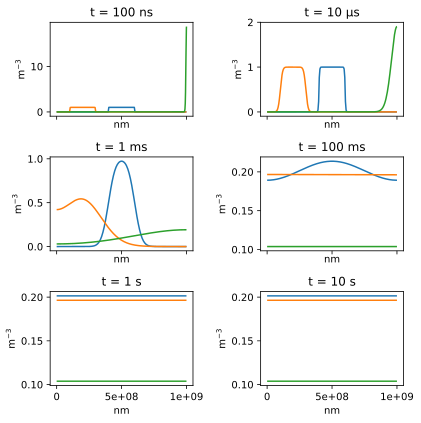

In [6]:
def setup_bc_isolated(model):
    pass
c=run(test_mu,test_ic,setup_bc_isolated)
plot_times(c,[[1e-7,1e-5],[1e-3,1e-1],[1,1e1]])

## Dirichlet boundary conditions $c(0)=0$, $c(L)=0$

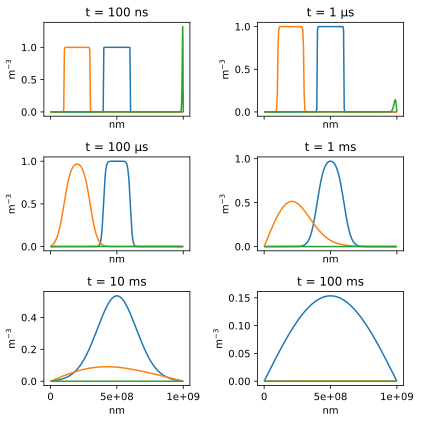

In [7]:
def setup_bc_zero(model):
    for species in model.species:
        species.bc = [models.Zero('electrode0'),models.Zero('electrode1')]
c=run(test_mu,test_ic,setup_bc_zero)
plot_times(c,[[1e-7,1e-6],[1e-4,1e-3],[1e-2,1e-1]])

## Periodic boundary conditions $c(L)=c(0)$

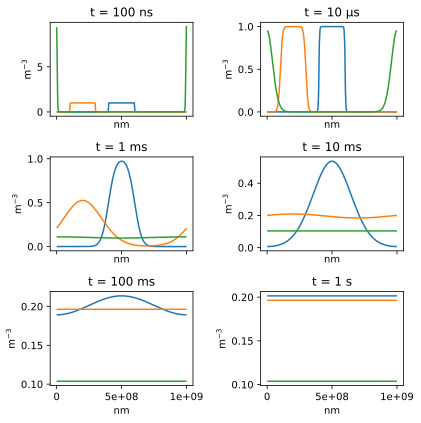

In [8]:
def setup_bc_periodic(model):
    for species in model.species:
        species.bc = [models.Equal(species, 'electrode0')]
c=run(test_mu,test_ic,setup_bc_periodic)
plot_times(c,[[1e-7,1e-5],[1e-3,1e-2],[1e-1,1]])


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
